## Job Search

#### John Stachurski

A McCall job search model with correlated state process, using Jovanovic-style continuation value function iteration, linear interpolation and Monte Carlo integration.


Job search with persistent and transitory components to wages.

Wages are given by

$$    w = \exp(z) + y $$

$$    y \sim \exp(μ + s ζ)  $$

$$    z' = d + ρ z + σ ε $$

with ζ and ε both iid and N(0, 1).   The value function is

$$ v(w, z) = \max\{ u(w) / (1-β), u(c) + β E v(w', z')\} $$

The continuation value function satisfies

$$    f(z) = u(c) + β E \max\{ u(w') / (1-β), f(z') \} $$

From $f$ we can solve the optimal stopping problem by stopping when

$$    u(w) / (1-β) > f(z) $$

For utility we take $u(c) = ln(c)$.  The reservation wage is the wage where
equality holds, or

$$    w^*(z) = \exp(f^*(z) (1-β)) $$

Our aim is to solve for the reservation rule.  We do this by first computing
$f^*$ as the fixed point of the contraction map

$$    Qf(z) = u(c) + β E \max\{ u(w') / (1-β), f(z') \} $$

When we iterate, f is stored as a vector of values on a grid and these points
are interpolated into a function as necessary.

Interpolation is piecewise linear.

The integral in the definition of Qf is calculated by Monte Carlo.



In [34]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from lininterp import interp1d
from numba import jit, njit, prange

from quantecon import tic, toc

In [41]:
class JobSearch:

    def __init__(self,
                 μ=0.0, 
                 s=1.0, 
                 d=0.0, 
                 ρ=0.9, 
                 σ=0.1, 
                 β=0.98, 
                 c=5,
                 mc_size=5000,
                 grid_size=200):

        self.μ, self.s, self.d,  = μ, s, d, 
        self.ρ, self.σ, self.β, self.c = ρ, σ, β, c 

        # Set up grid
        z_mean = d / (1 - ρ)
        z_sd = np.sqrt(σ / (1 - ρ**2))
        k = 3  # std devs from mean
        a, b = z_mean - k * z_sd, z_mean + k * z_sd
        self.z_grid = np.linspace(a, b, grid_size)

        # Store shocks
        self.mc_size = mc_size
        self.e_draws = randn(2, mc_size)

    def pack_parameters(self):
        return self.μ, self.s, self.d, \
                self.ρ, self.σ, self.β, self.c
        
    def operator_factory(self):
        μ, s, d, ρ, σ, β, c = self.pack_parameters()
        e_draws = self.e_draws
        z_grid = self.z_grid
        M = e_draws.shape[1]

        @njit(parallel=True)
        def Q(f_in, f_out):       
            for i in prange(len(z_grid)):
                z = z_grid[i]
                expectation = 0.0
                for m in range(M):
                    e1, e2 = e_draws[:, m]
                    z_next = d + ρ * z + σ * e1
                    go_val = interp1d(z_grid, f_in, z_next) # f(z') 
                    y_next = np.exp(μ + s * e2)             # y' draw
                    w_next = np.exp(z_next) + y_next        # w' draw
                    stop_val = np.log(w_next) / (1 - β)    
                    expectation += max(stop_val, go_val)
                expectation = expectation / M 
                f_out[i] = np.log(c) + β * expectation
        return Q

In [46]:
def compute_fixed_point(js,
                        tol=1e-4, 
                        max_iter=1000, 
                        verbose=True,
                        print_skip=25): 

    Q = js.operator_factory()
    # Set initial condition
    f_init = np.log(js.c) * np.ones(len(js.z_grid))
    f_out = np.empty_like(f_init)

    # Set up loop
    f_in = f_init
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        Q(f_in, f_out)
        error = np.max(np.abs(f_in - f_out))
        i += 1
        if i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        f_in[:] = f_out

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return f_out

In [47]:
js = JobSearch(mc_size=1000)


In [48]:
js.mc_size

1000

In [49]:
tic()
f_star = compute_fixed_point(js, verbose=True)
toc()

Error at iteration 25 is 0.6439704038962617.
Error at iteration 50 is 0.14679188192533843.
Error at iteration 75 is 0.04306009733092253.
Error at iteration 100 is 0.0136849351267756.
Error at iteration 125 is 0.004444957677932848.
Error at iteration 150 is 0.0014522136502108651.
Error at iteration 175 is 0.00047509025363012825.
Error at iteration 200 is 0.00015557383126463264.

Converged in 210 iterations.
TOC: Elapsed: 0:00:7.03


7.037079572677612

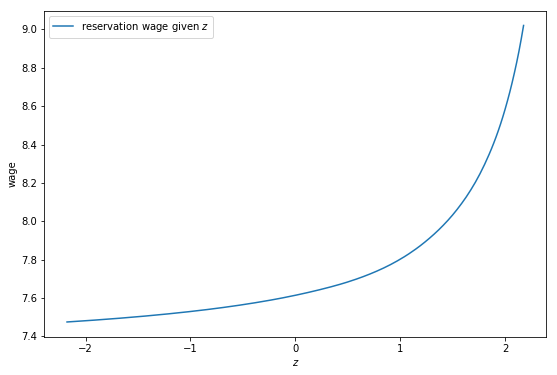

In [50]:
res_wage_function = np.exp(f_star * (1 - js.β))

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(js.z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

### Let's try higher unemployment compensation

In [51]:
js.c

5

In [52]:
js.c = 8

In [56]:
f_star = compute_fixed_point(js, verbose=True)

Error at iteration 25 is 0.8354878297147934.
Error at iteration 50 is 0.24765692606112566.
Error at iteration 75 is 0.09558046230624484.
Error at iteration 100 is 0.03985565919086298.
Error at iteration 125 is 0.016995512247945044.
Error at iteration 150 is 0.007300610714722211.
Error at iteration 175 is 0.003142816032607243.
Error at iteration 200 is 0.0013540098935749256.
Error at iteration 225 is 0.0005834202939922761.
Error at iteration 250 is 0.00025136209006859644.
Error at iteration 275 is 0.00010832739918953393.

Converged in 278 iterations.


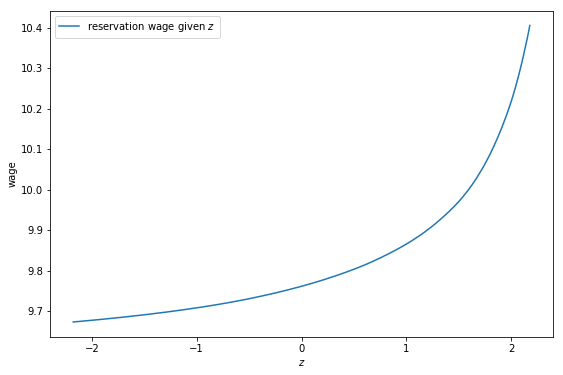

In [58]:
res_wage_function = np.exp(f_star * (1 - js.β))

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(js.z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()